In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np
from matplotlib_venn import venn3

Experimentalists have already chosen 4 genes to CRISPR KO based on several factors. These are the KO genes and associated expected phenotypes:
- CDKN1A (control) -  we expect an increased susceptibility of cells to radiation (faster rate of apoptosis)
- SPATA18 (ChatGPT, RadBioDB) - increase susceptibility to radiation, potential mitochondrial phenotype in cell painting data
- PTCHD4 (Kosmos, RadBioDB) - increase susceptibility to radiation
- MYH9 (KOSMOS, DAG-GNN, RadBioDB) - potential cell shape phenotype in cell painting

There are 6 "lines of evidence" ranked from least compute intensive to most compute intensive (including pretraining):
- DE gene sets
- Cell painting phenotype predictors, based on linear regression
- DAG-GNN
- ChatGPT (AI)
- KOSMOS (AI)

Each of these has an associated gene list that is hypothesized to play a role in radiation response. 

Our objective is to understand the enrichment of "interesting hypotheses genes" which should be defined by some function of novelty, likelihood of phenotypic differences observed in cell painting, and known pathway validation.
- Novelty: N(# Pubmed x radiation hits, in RadBioDB)
- Cell Painting Phenotype: CPP(is cell structure gene?, predictive capability in cell painting linear regression, predictive capability for Cas9)
- Pathway Validation: PV(size of child set in pathway graph related to known radiation response WPs ) 

We can rank all genes according to this function, and determine which method produces the most interesting hypotheses.

Then using simulation, we can KO the interesting hypotheses (as well as the already determined KO genes) and figure out the expected change in phenotype or expected information gain in the causal graphs.

Another point of interest is a set of genes that can be KOs to deconvolve time and dose rate signals. Currently, all data points to a dominant temporal signal. The only place that doesn't is the DAG-GNN neighborhood graphs that don't have a ton of overlap in dose rate gene sets (see below). 

In [3]:
KO_genes = ["CDKN1A", "SPATA18", "PTCHD4", "MYH9"]

First we analyze the DAG-GNN gene sets, and their context versus invariance overlaps. We identify, where in the ranked list and in the overlaps the four KO genes occur

In [4]:
context_specific_graphs = "./bootstrap_graphs2"
invariant_graphs = "./bootstrap_graphs3"

In [5]:
genes_100_tfs = {}
genes_neighborhoods = {}
doses = ["F", "G", "H", "I", "J"]
for d in doses:
    genes_100_tfs[d] = pd.read_csv(f"{context_specific_graphs}/top_100_dag_gnn_{d}.csv", header=None).iloc[:,0].to_list()
    genes_neighborhoods[d] = pd.read_csv(f"{context_specific_graphs}/rad_sub_dag_gnn_{d}_ranked.csv", header=0).iloc[:,0].to_list()

genes_100_tfs['all_doses'] = pd.read_csv(f"{invariant_graphs}/dag_gnn_combined_top_100_tfs.csv", header=None).iloc[:,0].to_list()
genes_neighborhoods['all_doses_dose_rate'] = pd.read_csv(f"{invariant_graphs}/rad_sub_dag_gnn_combined_ranked.csv", header=0).iloc[:,0].to_list()
genes_neighborhoods['all_doses_week'] = pd.read_csv(f"{invariant_graphs}/week_sub_dag_gnn_combined_ranked.csv", header=0).iloc[:,0].to_list()

In [6]:
genes_kosmos = pd.read_csv("../prior_knowledge/Genes extracted from LLM outputs - KOSMOS 2 (Becca).csv", header=0)["Gene Symbol"].to_list()
genes_chatgpt = pd.read_csv("../prior_knowledge/radiation_response_genes_132_chatgpt.csv", header=0)["Gene"].to_list()

In [6]:

for ko in KO_genes:
    for i, val in genes_100_tfs.items():
        if ko in val:
            print(f"TFs: {ko } in  {i} ranked {list(val).index(ko)}")
    for i, val in genes_neighborhoods.items():
        if ko in val:
            print(f"Neighborhood: {ko } in  {i} ranked {list(val).index(ko)}")
    if ko in genes_kosmos:
        print(f"KOSMOS: {ko}")
    if ko in genes_chatgpt:
        print(f"ChatGPT: {ko}")

TFs: CDKN1A in  F ranked 85
TFs: CDKN1A in  G ranked 27
TFs: CDKN1A in  H ranked 14
TFs: CDKN1A in  I ranked 58
TFs: CDKN1A in  J ranked 47
Neighborhood: CDKN1A in  H ranked 15
Neighborhood: CDKN1A in  I ranked 6
Neighborhood: CDKN1A in  J ranked 3
Neighborhood: CDKN1A in  all_doses_dose_rate ranked 94
Neighborhood: CDKN1A in  all_doses_week ranked 85
ChatGPT: CDKN1A
KOSMOS: PTCHD4
ChatGPT: PTCHD4
TFs: MYH9 in  all_doses ranked 99
Neighborhood: MYH9 in  H ranked 77
Neighborhood: MYH9 in  all_doses_dose_rate ranked 264
KOSMOS: MYH9


In [7]:
from supervenn import supervenn
# keys, values = zip(*genes_100_tfs.items())
# values = [set(v) for v in values]
# keys = [k for k in keys]
# values.append(set(genes_kosmos))
# values.append(set(genes_chatgpt))
# keys.append("kosmos")
# keys.append("chatgpt")
# supervenn(values, keys, sets_ordering="minimize gaps", fontsize=5)


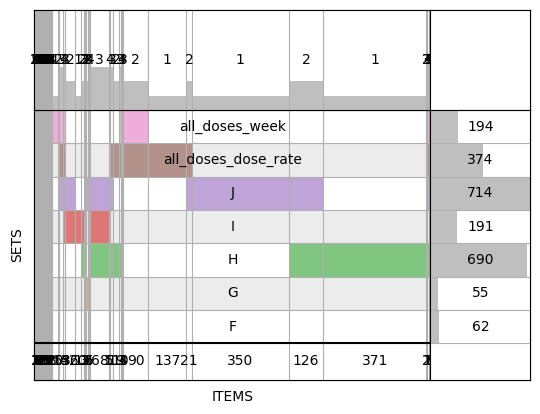

In [8]:
keys, values = zip(*genes_neighborhoods.items())
values = [set(v) for v in values]
keys = [k for k in keys]
# values.append(set(genes_kosmos))
# values.append(set(genes_chatgpt))
# keys.append("kosmos")
# keys.append("chatgpt")
supervenn(values, keys, fontsize=10)#, sets_ordering="size")

In [1]:
from typing import List, Any
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from Bio import Entrez
from gprofiler import GProfiler

def pathway_enrichment(genes) -> List[Any]:
    """Given a list of genes, perform pathway enrichment using knowledge databases

    Args:
        genes (set(str)): Set of genes with string identifiers
        
    Returns:
        (List[Any]): Return a list of named pathways and scores for each 
    """
    pathways = ["WP:WP45", "WP:WP254", "WP:WP707", "WP:WP710", "WP:WP1530", "WP:WP1772", "WP:WP3391", "WP:WP4946", "WP:WP4963", "WP:WP5434", "WP:WP5475"]
    gp = GProfiler(return_dataframe=True)

    results = gp.profile(
        organism="hsapiens",
        query=genes,
        sources=["GO:BP", "KEGG", "REAC", "WP"],
        user_threshold=0.05,
        significance_threshold_method="fdr"
    )

    # Sort by adjusted p-value
    results = results.sort_values("p_value")
    return results.query("native in @pathways")
    
def novelty_score(genes) -> List[int]:
    """Given a list of genes, compute the novelty score as a function of Pubmed hits and RadBioDB hits

    Args:
        genes (set(str)): Set of genes with string identifiers

    Returns:
        List[int]: Return a list of scores from 1-3, 1 indicating highly novel
    """
    data_for_fitting = pd.read_csv("../prior_knowledge/novelty_score.csv", header=0)
    radbio = pd.read_csv("../prior_knowledge/low_dose_genes_radbiobase.csv", header=0)["gene"].to_list()

    X = data_for_fitting[["RadBioDB","Pubmed radiation hits"]].to_numpy().astype(int) #
    print(X.shape)
    y = data_for_fitting["Novelty score"].to_numpy().astype(int)
    clf = DecisionTreeClassifier()
    clf.fit(X,y)
    Entrez.email = "shahashka@uchicago.edu"
    pmid_hits = []
    radbio_hit = []
    for g in genes:
        radbio_hit.append(1 if g in radbio else 0)
        handle = Entrez.esearch(
            db="pubmed",
            term=f"radiation {g}",
            retmax=1000
        )
        record = Entrez.read(handle)
        handle.close()

        pmids = record["IdList"]
        pmid_hits.append(len(pmids))
    X_eval = np.column_stack([radbio_hit, pmid_hits])
    print(X_eval.shape)
    n_scores = clf.predict(X_eval)
    return n_scores
    
def cell_painting_phenotype_prediction_score(genes, phenotypes):
    print("TODO")
    
def pathway_validation_score(genes, pathways):
    print("TODO")

In [11]:
ns_dag_gnn = novelty_score(genes_neighborhoods["all_doses_dose_rate"][0:100])
ns_kosmos = novelty_score(genes_kosmos[0:100])
ns_chatgpt = novelty_score(genes_chatgpt[0:100])

(18, 2)
(100, 2)
(18, 2)
(73, 2)
(18, 2)
(100, 2)


<Axes: xlabel='novelty_scores', ylabel='Count'>

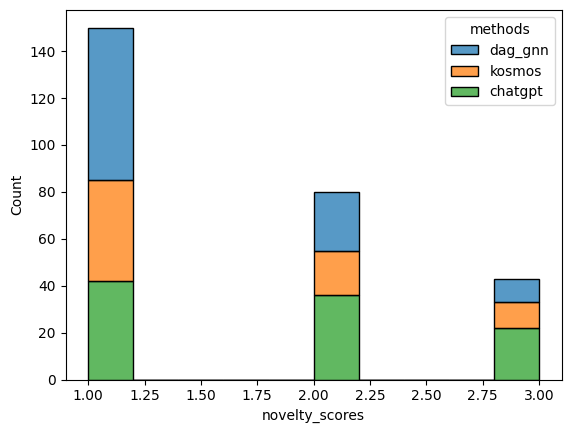

In [12]:
df = pd.DataFrame()
df["methods"] = len(ns_dag_gnn)*["dag_gnn"] + len(ns_kosmos)*["kosmos"] + len(ns_chatgpt)*["chatgpt"]
df["novelty_scores"] = np.concatenate([ns_dag_gnn,ns_kosmos, ns_chatgpt])
sns.histplot(data=df, x="novelty_scores", hue="methods", multiple="stack")

In [7]:
df = pathway_enrichment(genes_neighborhoods["F"])
print(df[['name', 'p_value']])


                                                   name   p_value
572                                           Apoptosis  0.003456
678             DNA damage response only ATM dependent   0.005560
693     Senescence associated secretory phenotype SASP   0.005927
760                                     Cancer pathways  0.007440
761                                 DNA damage response  0.007440
807             miRNA regulation of DNA damage response  0.008742
1017                 Apoptosis modulation and signaling  0.015854
1064                   p53 transcriptional gene network  0.018175
1084  Hallmark of cancer sustaining proliferative si...  0.018876
1462                         G1 to S cell cycle control  0.034143


In [13]:
bnl_df = pd.read_csv("../prior_knowledge/cell_painting_phenotype_genes_brookhaven.csv")
sets_bnl = bnl_df.groupby(by=['phenotype_name'])
all_genes_bnl = bnl_df['gene_name'].to_list()
all_genes_bnl = [g.split("_")[0] for g in all_genes_bnl]
print(all_genes_bnl)


['PTX3', 'dose', 'MCAM', 'PTGR1', 'B3GNT5', 'EME2', 'BCL2L1', 'MCAM', 'DDIT4', 'SLC35D1', 'TNFRSF12A', 'PAPPA2', 'dose', 'HPCAL1', 'TFRC', 'MYL9', 'EPGN', 'CYTIP', 'EFEMP1', 'ITGB1', 'TRIM16L', 'TRIM16', 'RCAN1', 'DACH1', 'dose', 'PEA15', 'CMKLR1', 'CYTIP', 'CEP192', 'EFEMP1', 'RCAN1', 'LDB2', 'dose', 'DNER', 'PEA15', 'ANXA4', 'GNG2', 'UBA52', 'EME2', 'ADAM19', 'dose']


In [ ]:
for g in set(all_genes_bnl):
    for i, val in genes_100_tfs.items():
        if g in val:
            print(f"TFs: {g } in  {i} ranked {list(val).index(g)}")
    for i, val in genes_neighborhoods.items():
        if g in val:
            print(f"Neighborhood: {g } in  {i} ranked {list(val).index(g)}")
    if g in genes_kosmos:
        print(f"KOSMOS: {g}")
    if g in genes_chatgpt:
        print(f"ChatGPT: {g}")

Neighborhood: TNFRSF12A in  J ranked 42
Neighborhood: TNFRSF12A in  all_doses_dose_rate ranked 166
TFs: MCAM in  H ranked 55
TFs: MCAM in  I ranked 75
TFs: MCAM in  J ranked 69
Neighborhood: MCAM in  H ranked 447
Neighborhood: MCAM in  I ranked 182
Neighborhood: MCAM in  J ranked 532
Neighborhood: BCL2L1 in  H ranked 684
Neighborhood: BCL2L1 in  I ranked 63
Neighborhood: BCL2L1 in  J ranked 585
Neighborhood: BCL2L1 in  all_doses_dose_rate ranked 361
Neighborhood: MYL9 in  H ranked 93
Neighborhood: PEA15 in  H ranked 341
Neighborhood: PEA15 in  all_doses_dose_rate ranked 363
TFs: DDIT4 in  F ranked 79
TFs: DDIT4 in  G ranked 69
TFs: DDIT4 in  H ranked 11
TFs: DDIT4 in  I ranked 19
TFs: DDIT4 in  J ranked 29
Neighborhood: DDIT4 in  H ranked 49
Neighborhood: DDIT4 in  I ranked 15
Neighborhood: DDIT4 in  J ranked 443
Neighborhood: ANXA4 in  H ranked 510
Neighborhood: ITGB1 in  H ranked 407
Neighborhood: ITGB1 in  J ranked 50
Neighborhood: TRIM16 in  H ranked 191
TFs: TFRC in  F ranked 21
T

: 

: 

In [ ]:
len(set(all_genes_bnl))

31

: 

: 

: 

: 